In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from argparse import ArgumentParser
from double_net.double_net import DoubleNet, train_loop, train_loop_sinkhorn_decay, test_loop, test_loop_random_start
from double_net import datasets as ds
import time
import double_net.plot_utils as pu
import importlib
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
device

'cuda'

In [4]:
parser = ArgumentParser()
parser.add_argument('--random-seed', type=int, default=123456789)
parser.add_argument('--num-examples', type=int, default=131072 * 4)
parser.add_argument('--test-num-examples', type=int, default=1000)
parser.add_argument('--test-iter', type=int, default=5)
parser.add_argument('--n-agents', type=int, default=1)
parser.add_argument('--n-items', type=int, default=2)
parser.add_argument('--num-epochs', type=int, default=100)
parser.add_argument('--batch-size', type=int, default=128 * 32)
parser.add_argument('--test-batch-size', type=int, default=10000)
parser.add_argument('--model-lr', type=float, default=1e-3)
parser.add_argument('--misreport-lr', type=float, default=1e-1)
parser.add_argument('--misreport-iter', type=int, default=25)
parser.add_argument('--test-misreport-iter', type=int, default=2000)
parser.add_argument('--rho', type=float, default=1)
parser.add_argument('--rho-incr-iter', type=int, default=2)
parser.add_argument('--rho-incr-amount', type=float, default=1.0)
parser.add_argument('--lagr-update-iter', type=int, default=100)
parser.add_argument('--rgt-start', type=int, default=0)
parser.add_argument('--sinkhorn-epsilon', type=float, default=5e-2)
parser.add_argument('--sinkhorn-rounds', type=int, default=10)

dataset_name = ""
args = parser.parse_args(args=[])
args

Namespace(batch_size=4096, lagr_update_iter=100, misreport_iter=25, misreport_lr=0.1, model_lr=0.001, n_agents=1, n_items=2, num_epochs=100, num_examples=524288, random_seed=123456789, rgt_start=0, rho=1, rho_incr_amount=1.0, rho_incr_iter=2, sinkhorn_epsilon=0.05, sinkhorn_rounds=10, test_batch_size=10000, test_iter=5, test_misreport_iter=2000, test_num_examples=1000)

In [5]:
def generate_1x2_exp_data(num_examples, lambda_1, lambda_2):
    item_one = np.random.exponential(scale=1/lambda_1, size=(num_examples, 1, 1))
    item_two = np.random.exponential(scale=1/lambda_2, size=(num_examples, 1, 1))
    item_one = torch.from_numpy(item_one)
    item_two = torch.from_numpy(item_two)
    
    return torch.cat([item_one, item_two], dim=-1).type(torch.float)

In [6]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)

item_ranges = torch.tensor([[[0., np.inf],
                            [0., np.inf]]])
clamp_op = ds.get_clamp_op(item_ranges)

model = DoubleNet(
    args.n_agents, args.n_items, item_ranges, args.sinkhorn_epsilon, args.sinkhorn_rounds, marginal_choice='additive'
).to(device)

train_data = generate_1x2_exp_data(args.num_examples, 2.0, 1.0).to(device)
train_loader = ds.Dataloader(train_data, batch_size=args.batch_size, shuffle=True)

In [7]:
%%time
mean_rgt, mean_pay, lagr_mults = train_loop(model, train_loader, args, device=device)
# mean_rgt, mean_pay, lagr_mults = train_loop_sinkhorn_decay(model, train_loader, args, device=device, decay_iter=500, decay_mult=.99)

  1%|          | 1/100 [03:10<5:13:53, 190.24s/it]

{'regret_max': 2.7515854835510254, 'regret_mean': 0.038950104266405106, 'regret_mults': tensor([[3.0303]], device='cuda:0'), 'payment': 0.6521004438400269}


  2%|▏         | 2/100 [06:47<5:24:00, 198.37s/it]

{'regret_max': 0.33649253845214844, 'regret_mean': 0.013035515323281288, 'regret_mults': tensor([[4.8253]], device='cuda:0'), 'payment': 0.673438549041748}


  3%|▎         | 3/100 [10:28<5:31:28, 205.04s/it]

{'regret_max': 0.22700834274291992, 'regret_mean': 0.009154384955763817, 'regret_mults': tensor([[5.6032]], device='cuda:0'), 'payment': 0.6614737510681152}


  4%|▍         | 4/100 [14:08<5:35:28, 209.67s/it]

{'regret_max': 0.2302875518798828, 'regret_mean': 0.0073363278061151505, 'regret_mults': tensor([[8.6061]], device='cuda:0'), 'payment': 0.6537030339241028}


  5%|▌         | 5/100 [17:46<5:36:05, 212.26s/it]

{'regret_max': 0.1721482276916504, 'regret_mean': 0.0054994793608784676, 'regret_mults': tensor([[10.8198]], device='cuda:0'), 'payment': 0.6445739269256592}


  6%|▌         | 6/100 [21:16<5:31:11, 211.39s/it]

{'regret_max': 0.16652727127075195, 'regret_mean': 0.005151635967195034, 'regret_mults': tensor([[12.1141]], device='cuda:0'), 'payment': 0.6381469964981079}


  7%|▋         | 7/100 [24:35<5:22:02, 207.77s/it]

{'regret_max': 0.11557292938232422, 'regret_mean': 0.0036322837695479393, 'regret_mults': tensor([[13.2458]], device='cuda:0'), 'payment': 0.6363275647163391}


  8%|▊         | 8/100 [27:42<5:08:51, 201.42s/it]

{'regret_max': 0.1560211181640625, 'regret_mean': 0.003153229830786586, 'regret_mults': tensor([[16.8756]], device='cuda:0'), 'payment': 0.6294441819190979}


  9%|▉         | 9/100 [30:44<4:56:45, 195.67s/it]

{'regret_max': 0.15471172332763672, 'regret_mean': 0.0029906178824603558, 'regret_mults': tensor([[17.7068]], device='cuda:0'), 'payment': 0.6223491430282593}


 10%|█         | 10/100 [33:49<4:48:35, 192.40s/it]

{'regret_max': 0.08093833923339844, 'regret_mean': 0.0013145003467798233, 'regret_mults': tensor([[18.5280]], device='cuda:0'), 'payment': 0.6233035326004028}


 11%|█         | 11/100 [36:52<4:41:20, 189.66s/it]

{'regret_max': 0.13809919357299805, 'regret_mean': 0.0018823470454663038, 'regret_mults': tensor([[22.6385]], device='cuda:0'), 'payment': 0.6176435947418213}


 12%|█▏        | 12/100 [40:07<4:40:18, 191.12s/it]

{'regret_max': 0.12927627563476562, 'regret_mean': 0.001730891759507358, 'regret_mults': tensor([[23.1826]], device='cuda:0'), 'payment': 0.6146290302276611}


 13%|█▎        | 13/100 [43:20<4:38:20, 191.96s/it]

{'regret_max': 0.11838388442993164, 'regret_mean': 0.0013178428635001183, 'regret_mults': tensor([[24.2258]], device='cuda:0'), 'payment': 0.6150293946266174}


 14%|█▍        | 14/100 [46:28<4:33:20, 190.70s/it]

{'regret_max': 0.08357524871826172, 'regret_mean': 0.0012696472695097327, 'regret_mults': tensor([[24.7730]], device='cuda:0'), 'payment': 0.6147446632385254}


 15%|█▌        | 15/100 [49:34<4:28:09, 189.29s/it]

{'regret_max': 0.0835113525390625, 'regret_mean': 0.0010274481028318405, 'regret_mults': tensor([[26.1417]], device='cuda:0'), 'payment': 0.6159986257553101}


 16%|█▌        | 16/100 [52:43<4:24:49, 189.16s/it]

{'regret_max': 0.13454055786132812, 'regret_mean': 0.0013280549319460988, 'regret_mults': tensor([[26.7404]], device='cuda:0'), 'payment': 0.6115788221359253}


 17%|█▋        | 17/100 [55:50<4:20:36, 188.39s/it]

{'regret_max': 0.09682655334472656, 'regret_mean': 0.0008047355804592371, 'regret_mults': tensor([[27.5006]], device='cuda:0'), 'payment': 0.6160049438476562}


 18%|█▊        | 18/100 [58:55<4:16:23, 187.61s/it]

{'regret_max': 0.10568428039550781, 'regret_mean': 0.0013616408687084913, 'regret_mults': tensor([[29.1422]], device='cuda:0'), 'payment': 0.6102067828178406}


 19%|█▉        | 19/100 [1:02:01<4:12:19, 186.91s/it]

{'regret_max': 0.09053707122802734, 'regret_mean': 0.0011985572054982185, 'regret_mults': tensor([[29.5477]], device='cuda:0'), 'payment': 0.6101384162902832}


 20%|██        | 20/100 [1:05:06<4:08:31, 186.39s/it]

{'regret_max': 0.1911153793334961, 'regret_mean': 0.0016148469876497984, 'regret_mults': tensor([[30.6036]], device='cuda:0'), 'payment': 0.6053380966186523}


 21%|██        | 21/100 [1:08:14<4:06:05, 186.91s/it]

{'regret_max': 0.07810688018798828, 'regret_mean': 0.0006693449104204774, 'regret_mults': tensor([[32.6216]], device='cuda:0'), 'payment': 0.6122508645057678}


 22%|██▏       | 22/100 [1:11:24<4:04:11, 187.84s/it]

{'regret_max': 0.06992912292480469, 'regret_mean': 0.0007868445245549083, 'regret_mults': tensor([[33.4102]], device='cuda:0'), 'payment': 0.6139248609542847}


 23%|██▎       | 23/100 [1:14:30<4:00:10, 187.15s/it]

{'regret_max': 0.13384580612182617, 'regret_mean': 0.001488412730395794, 'regret_mults': tensor([[33.7632]], device='cuda:0'), 'payment': 0.6080939769744873}


 24%|██▍       | 24/100 [1:17:35<3:56:17, 186.55s/it]

{'regret_max': 0.11569833755493164, 'regret_mean': 0.0008514474611729383, 'regret_mults': tensor([[34.1591]], device='cuda:0'), 'payment': 0.6038380861282349}


 25%|██▌       | 25/100 [1:20:42<3:53:37, 186.90s/it]

{'regret_max': 0.12388324737548828, 'regret_mean': 0.0006270059966482222, 'regret_mults': tensor([[35.5676]], device='cuda:0'), 'payment': 0.6131130456924438}


 26%|██▌       | 26/100 [1:23:50<3:50:55, 187.23s/it]

{'regret_max': 0.06864261627197266, 'regret_mean': 0.0006085472414270043, 'regret_mults': tensor([[36.0835]], device='cuda:0'), 'payment': 0.6138780117034912}


 27%|██▋       | 27/100 [1:26:55<3:46:53, 186.49s/it]

{'regret_max': 0.09666013717651367, 'regret_mean': 0.0014803055673837662, 'regret_mults': tensor([[36.4580]], device='cuda:0'), 'payment': 0.6031166315078735}


 28%|██▊       | 28/100 [1:30:03<3:44:15, 186.89s/it]

{'regret_max': 0.09412670135498047, 'regret_mean': 0.0007605300634168088, 'regret_mults': tensor([[42.1601]], device='cuda:0'), 'payment': 0.6084724068641663}


 29%|██▉       | 29/100 [1:33:10<3:41:07, 186.87s/it]

{'regret_max': 0.05357170104980469, 'regret_mean': 0.0006186918471939862, 'regret_mults': tensor([[43.7695]], device='cuda:0'), 'payment': 0.6057438254356384}


 30%|███       | 30/100 [1:36:18<3:38:26, 187.24s/it]

{'regret_max': 0.08455085754394531, 'regret_mean': 0.0007892476860433817, 'regret_mults': tensor([[45.9260]], device='cuda:0'), 'payment': 0.6045106649398804}


 31%|███       | 31/100 [1:39:27<3:36:01, 187.85s/it]

{'regret_max': 0.13770484924316406, 'regret_mean': 0.0006114059360697865, 'regret_mults': tensor([[47.9645]], device='cuda:0'), 'payment': 0.6088129281997681}


 32%|███▏      | 32/100 [1:42:38<3:33:46, 188.63s/it]

{'regret_max': 0.06664180755615234, 'regret_mean': 0.0003630481078289449, 'regret_mults': tensor([[48.4847]], device='cuda:0'), 'payment': 0.6128290295600891}


 33%|███▎      | 33/100 [1:45:39<3:28:10, 186.43s/it]

{'regret_max': 0.20042848587036133, 'regret_mean': 0.004623258486390114, 'regret_mults': tensor([[49.5493]], device='cuda:0'), 'payment': 0.5679689049720764}


 34%|███▍      | 34/100 [1:48:45<3:24:52, 186.24s/it]

{'regret_max': 0.06284713745117188, 'regret_mean': 0.0002745012752711773, 'regret_mults': tensor([[50.2312]], device='cuda:0'), 'payment': 0.6047414541244507}


 35%|███▌      | 35/100 [1:51:54<3:22:34, 186.99s/it]

{'regret_max': 0.06863260269165039, 'regret_mean': 0.0004315284313634038, 'regret_mults': tensor([[50.7705]], device='cuda:0'), 'payment': 0.6100103855133057}


 36%|███▌      | 36/100 [1:55:03<3:20:15, 187.74s/it]

{'regret_max': 0.057704925537109375, 'regret_mean': 0.00033878014073707163, 'regret_mults': tensor([[52.3591]], device='cuda:0'), 'payment': 0.612942099571228}


 37%|███▋      | 37/100 [1:58:13<3:17:48, 188.39s/it]

{'regret_max': 0.07658052444458008, 'regret_mean': 0.00041009121923707426, 'regret_mults': tensor([[52.9348]], device='cuda:0'), 'payment': 0.6122950315475464}


 38%|███▊      | 38/100 [2:01:23<3:15:03, 188.76s/it]

{'regret_max': 0.06036996841430664, 'regret_mean': 0.0003848183841910213, 'regret_mults': tensor([[55.0388]], device='cuda:0'), 'payment': 0.6109402179718018}


 39%|███▉      | 39/100 [2:04:33<3:12:18, 189.16s/it]

{'regret_max': 0.0632028579711914, 'regret_mean': 0.0003615081077441573, 'regret_mults': tensor([[55.5737]], device='cuda:0'), 'payment': 0.6130111217498779}


 40%|████      | 40/100 [2:07:41<3:09:01, 189.02s/it]

{'regret_max': 0.08096837997436523, 'regret_mean': 0.00040039868326857686, 'regret_mults': tensor([[58.9110]], device='cuda:0'), 'payment': 0.6096136569976807}


 41%|████      | 41/100 [2:10:47<3:04:56, 188.08s/it]

{'regret_max': 0.18666839599609375, 'regret_mean': 0.0007326273480430245, 'regret_mults': tensor([[59.4664]], device='cuda:0'), 'payment': 0.6038919687271118}


 42%|████▏     | 42/100 [2:13:53<3:01:01, 187.26s/it]

{'regret_max': 0.1385326385498047, 'regret_mean': 0.001195964403450489, 'regret_mults': tensor([[59.8284]], device='cuda:0'), 'payment': 0.5976299047470093}


 43%|████▎     | 43/100 [2:16:55<2:56:36, 185.90s/it]

{'regret_max': 0.05893135070800781, 'regret_mean': 0.0003113292041234672, 'regret_mults': tensor([[63.7919]], device='cuda:0'), 'payment': 0.6005599498748779}


 44%|████▍     | 44/100 [2:20:00<2:53:12, 185.57s/it]

{'regret_max': 0.0612945556640625, 'regret_mean': 0.0003002719022333622, 'regret_mults': tensor([[64.3666]], device='cuda:0'), 'payment': 0.6098922491073608}


 45%|████▌     | 45/100 [2:23:07<2:50:25, 185.91s/it]

{'regret_max': 0.0847463607788086, 'regret_mean': 0.000364585779607296, 'regret_mults': tensor([[64.7300]], device='cuda:0'), 'payment': 0.6114020347595215}


 46%|████▌     | 46/100 [2:26:14<2:47:42, 186.34s/it]

{'regret_max': 0.06693744659423828, 'regret_mean': 0.0003248556749895215, 'regret_mults': tensor([[65.0866]], device='cuda:0'), 'payment': 0.6110104918479919}


 47%|████▋     | 47/100 [2:29:22<2:44:56, 186.73s/it]

{'regret_max': 0.24679803848266602, 'regret_mean': 0.0008783443481661379, 'regret_mults': tensor([[67.2338]], device='cuda:0'), 'payment': 0.6087195873260498}


 48%|████▊     | 48/100 [2:32:24<2:40:39, 185.38s/it]

{'regret_max': 0.19729852676391602, 'regret_mean': 0.0006667029811069369, 'regret_mults': tensor([[67.6205]], device='cuda:0'), 'payment': 0.5833137631416321}


 49%|████▉     | 49/100 [2:35:33<2:38:23, 186.33s/it]

{'regret_max': 0.09287548065185547, 'regret_mean': 0.0003718866501003504, 'regret_mults': tensor([[68.2800]], device='cuda:0'), 'payment': 0.6048681139945984}


 50%|█████     | 50/100 [2:38:41<2:35:43, 186.86s/it]

{'regret_max': 0.050783634185791016, 'regret_mean': 0.0003071986138820648, 'regret_mults': tensor([[71.7106]], device='cuda:0'), 'payment': 0.6097166538238525}


 51%|█████     | 51/100 [2:41:46<2:32:18, 186.50s/it]

{'regret_max': 0.12387847900390625, 'regret_mean': 0.0005027295555919409, 'regret_mults': tensor([[72.0439]], device='cuda:0'), 'payment': 0.5993253588676453}


 52%|█████▏    | 52/100 [2:44:56<2:29:56, 187.42s/it]

{'regret_max': 0.06609773635864258, 'regret_mean': 0.0002586999617051333, 'regret_mults': tensor([[72.5789]], device='cuda:0'), 'payment': 0.6120955348014832}


 53%|█████▎    | 53/100 [2:48:03<2:26:42, 187.30s/it]

{'regret_max': 0.0919194221496582, 'regret_mean': 0.0005805491236969829, 'regret_mults': tensor([[77.6606]], device='cuda:0'), 'payment': 0.5983517169952393}


 54%|█████▍    | 54/100 [2:51:10<2:23:29, 187.17s/it]

{'regret_max': 0.15137863159179688, 'regret_mean': 0.0006747635779902339, 'regret_mults': tensor([[78.2565]], device='cuda:0'), 'payment': 0.5943489074707031}


 55%|█████▌    | 55/100 [2:54:20<2:20:58, 187.96s/it]

{'regret_max': 0.11075019836425781, 'regret_mean': 0.0003357224341016263, 'regret_mults': tensor([[79.1972]], device='cuda:0'), 'payment': 0.6047360301017761}


 56%|█████▌    | 56/100 [2:57:31<2:18:41, 189.13s/it]

{'regret_max': 0.04889059066772461, 'regret_mean': 0.0002484866126906127, 'regret_mults': tensor([[79.9243]], device='cuda:0'), 'payment': 0.6102114915847778}


 57%|█████▋    | 57/100 [3:00:43<2:16:09, 189.98s/it]

{'regret_max': 0.06607818603515625, 'regret_mean': 0.00033755850745365024, 'regret_mults': tensor([[80.8734]], device='cuda:0'), 'payment': 0.6083208918571472}


 58%|█████▊    | 58/100 [3:03:49<2:12:07, 188.76s/it]

{'regret_max': 0.08411788940429688, 'regret_mean': 0.0009028474451042712, 'regret_mults': tensor([[81.9967]], device='cuda:0'), 'payment': 0.5915625691413879}


 59%|█████▉    | 59/100 [3:06:55<2:08:25, 187.95s/it]

{'regret_max': 0.046591758728027344, 'regret_mean': 0.0003371820494066924, 'regret_mults': tensor([[82.8238]], device='cuda:0'), 'payment': 0.6028186082839966}


 60%|██████    | 60/100 [3:10:04<2:05:27, 188.18s/it]

{'regret_max': 0.053046226501464844, 'regret_mean': 0.0002474473731126636, 'regret_mults': tensor([[84.9662]], device='cuda:0'), 'payment': 0.6071344614028931}


 61%|██████    | 61/100 [3:13:13<2:02:26, 188.36s/it]

{'regret_max': 0.1926727294921875, 'regret_mean': 0.0005782950320281088, 'regret_mults': tensor([[104.4842]], device='cuda:0'), 'payment': 0.6068653464317322}


 62%|██████▏   | 62/100 [3:16:17<1:58:32, 187.18s/it]

{'regret_max': 0.12121200561523438, 'regret_mean': 0.0005702431662939489, 'regret_mults': tensor([[104.9747]], device='cuda:0'), 'payment': 0.5874453186988831}


 63%|██████▎   | 63/100 [3:19:25<1:55:27, 187.22s/it]

{'regret_max': 0.09161949157714844, 'regret_mean': 0.0004164562269579619, 'regret_mults': tensor([[105.2466]], device='cuda:0'), 'payment': 0.5982763171195984}


 64%|██████▍   | 64/100 [3:22:32<1:52:23, 187.31s/it]

{'regret_max': 0.07310104370117188, 'regret_mean': 0.00021491260849870741, 'regret_mults': tensor([[105.5624]], device='cuda:0'), 'payment': 0.5993475914001465}


 65%|██████▌   | 65/100 [3:25:42<1:49:41, 188.03s/it]

{'regret_max': 0.0706033706665039, 'regret_mean': 0.0001719259307719767, 'regret_mults': tensor([[106.6193]], device='cuda:0'), 'payment': 0.6064063906669617}


 66%|██████▌   | 66/100 [3:28:52<1:46:55, 188.70s/it]

{'regret_max': 0.08762645721435547, 'regret_mean': 0.00029346515657380223, 'regret_mults': tensor([[107.0069]], device='cuda:0'), 'payment': 0.6029332876205444}


 67%|██████▋   | 67/100 [3:32:03<1:44:05, 189.25s/it]

{'regret_max': 0.5401716232299805, 'regret_mean': 0.011411985382437706, 'regret_mults': tensor([[230.4212]], device='cuda:0'), 'payment': 0.22165963053703308}


 68%|██████▊   | 68/100 [3:35:29<1:43:40, 194.40s/it]

{'regret_max': 0.015355110168457031, 'regret_mean': 0.0002023369015660137, 'regret_mults': tensor([[232.0395]], device='cuda:0'), 'payment': 0.01202579028904438}


 69%|██████▉   | 69/100 [3:38:56<1:42:20, 198.07s/it]

{'regret_max': 0.013576507568359375, 'regret_mean': 0.00012290015001781285, 'regret_mults': tensor([[232.4787]], device='cuda:0'), 'payment': 0.011838718317449093}


 70%|███████   | 70/100 [3:42:23<1:40:27, 200.90s/it]

{'regret_max': 0.011557579040527344, 'regret_mean': 8.133816299960017e-05, 'regret_mults': tensor([[232.8342]], device='cuda:0'), 'payment': 0.011978523805737495}


 71%|███████   | 71/100 [3:45:54<1:38:35, 203.98s/it]

{'regret_max': 0.010050773620605469, 'regret_mean': 5.164217509445734e-05, 'regret_mults': tensor([[233.1271]], device='cuda:0'), 'payment': 0.01246859971433878}


 72%|███████▏  | 72/100 [3:49:18<1:35:11, 203.99s/it]

{'regret_max': 0.009121894836425781, 'regret_mean': 3.571504930732772e-05, 'regret_mults': tensor([[233.4376]], device='cuda:0'), 'payment': 0.01334381103515625}


 73%|███████▎  | 73/100 [3:52:42<1:31:41, 203.74s/it]

{'regret_max': 0.008480072021484375, 'regret_mean': 3.5431599826551974e-05, 'regret_mults': tensor([[233.5809]], device='cuda:0'), 'payment': 0.014415888115763664}


 74%|███████▍  | 74/100 [3:56:06<1:28:25, 204.06s/it]

{'regret_max': 0.008243560791015625, 'regret_mean': 3.2138628739630803e-05, 'regret_mults': tensor([[233.7419]], device='cuda:0'), 'payment': 0.015583422034978867}


 75%|███████▌  | 75/100 [3:59:29<1:24:54, 203.78s/it]

{'regret_max': 0.00815582275390625, 'regret_mean': 3.892082168022171e-05, 'regret_mults': tensor([[234.1008]], device='cuda:0'), 'payment': 0.0168182160705328}


 76%|███████▌  | 76/100 [4:02:53<1:21:25, 203.57s/it]

{'regret_max': 0.008069038391113281, 'regret_mean': 3.65252562914975e-05, 'regret_mults': tensor([[234.3154]], device='cuda:0'), 'payment': 0.01832074671983719}


 77%|███████▋  | 77/100 [4:06:16<1:17:59, 203.44s/it]

{'regret_max': 0.007941246032714844, 'regret_mean': 3.6297522456152365e-05, 'regret_mults': tensor([[234.5383]], device='cuda:0'), 'payment': 0.020222824066877365}


 78%|███████▊  | 78/100 [4:09:40<1:14:38, 203.56s/it]

{'regret_max': 0.008021354675292969, 'regret_mean': 6.174130248837173e-05, 'regret_mults': tensor([[235.0160]], device='cuda:0'), 'payment': 0.02217046171426773}


 79%|███████▉  | 79/100 [4:13:03<1:11:15, 203.58s/it]

{'regret_max': 0.008072853088378906, 'regret_mean': 6.142180063761771e-05, 'regret_mults': tensor([[235.6315]], device='cuda:0'), 'payment': 0.024241141974925995}


 80%|████████  | 80/100 [4:16:27<1:07:54, 203.73s/it]

{'regret_max': 0.008364677429199219, 'regret_mean': 0.00010580133675830439, 'regret_mults': tensor([[235.8511]], device='cuda:0'), 'payment': 0.026448708027601242}


 81%|████████  | 81/100 [4:19:51<1:04:32, 203.81s/it]

{'regret_max': 0.007641792297363281, 'regret_mean': 6.735622446285561e-05, 'regret_mults': tensor([[236.0638]], device='cuda:0'), 'payment': 0.027775878086686134}


 82%|████████▏ | 82/100 [4:23:16<1:01:12, 204.02s/it]

{'regret_max': 0.0074825286865234375, 'regret_mean': 0.00010192404442932457, 'regret_mults': tensor([[236.5278]], device='cuda:0'), 'payment': 0.030983904376626015}


 83%|████████▎ | 83/100 [4:26:39<57:45, 203.83s/it]  

{'regret_max': 0.008096694946289062, 'regret_mean': 8.505854930263013e-05, 'regret_mults': tensor([[237.2847]], device='cuda:0'), 'payment': 0.03506691753864288}


 84%|████████▍ | 84/100 [4:30:00<54:05, 202.83s/it]

{'regret_max': 0.0084381103515625, 'regret_mean': 0.00010901975474553183, 'regret_mults': tensor([[238.4694]], device='cuda:0'), 'payment': 0.041155822575092316}


 85%|████████▌ | 85/100 [4:33:14<50:05, 200.37s/it]

{'regret_max': 0.02043628692626953, 'regret_mean': 0.00013259986008051783, 'regret_mults': tensor([[239.6415]], device='cuda:0'), 'payment': 0.048974938690662384}


 86%|████████▌ | 86/100 [4:36:23<45:56, 196.88s/it]

{'regret_max': 0.00908660888671875, 'regret_mean': 0.00014126043242868036, 'regret_mults': tensor([[240.3310]], device='cuda:0'), 'payment': 0.06530018895864487}


 87%|████████▋ | 87/100 [4:39:25<41:40, 192.36s/it]

{'regret_max': 0.013915061950683594, 'regret_mean': 0.0001405186194460839, 'regret_mults': tensor([[240.5991]], device='cuda:0'), 'payment': 0.10422404855489731}


 88%|████████▊ | 88/100 [4:42:23<37:37, 188.09s/it]

{'regret_max': 0.06988096237182617, 'regret_mean': 0.0005955339292995632, 'regret_mults': tensor([[266.3934]], device='cuda:0'), 'payment': 0.17159853875637054}


 89%|████████▉ | 89/100 [4:45:19<33:48, 184.43s/it]

{'regret_max': 0.03607654571533203, 'regret_mean': 0.0006813303334638476, 'regret_mults': tensor([[268.5752]], device='cuda:0'), 'payment': 0.20968694984912872}


 90%|█████████ | 90/100 [4:48:18<30:28, 182.80s/it]

{'regret_max': 0.06601190567016602, 'regret_mean': 0.0010646615410223603, 'regret_mults': tensor([[274.0373]], device='cuda:0'), 'payment': 0.25265488028526306}


 91%|█████████ | 91/100 [4:51:33<27:57, 186.40s/it]

{'regret_max': 0.04895353317260742, 'regret_mean': 0.0006863645976409316, 'regret_mults': tensor([[274.5059]], device='cuda:0'), 'payment': 0.05809887871146202}


 92%|█████████▏| 92/100 [4:54:44<25:02, 187.79s/it]

{'regret_max': 0.008989334106445312, 'regret_mean': 8.2859092799481e-05, 'regret_mults': tensor([[274.6555]], device='cuda:0'), 'payment': 0.054751232266426086}


 93%|█████████▎| 93/100 [4:57:50<21:52, 187.43s/it]

{'regret_max': 0.010637283325195312, 'regret_mean': 8.631203672848642e-05, 'regret_mults': tensor([[275.4024]], device='cuda:0'), 'payment': 0.0799902006983757}


 94%|█████████▍| 94/100 [5:00:50<18:31, 185.18s/it]

{'regret_max': 0.011241912841796875, 'regret_mean': 8.872929174685851e-05, 'regret_mults': tensor([[275.4997]], device='cuda:0'), 'payment': 0.1450725793838501}


 95%|█████████▌| 95/100 [5:03:58<15:29, 185.98s/it]

{'regret_max': 0.1210896372795105, 'regret_mean': 0.001598974922671914, 'regret_mults': tensor([[289.4373]], device='cuda:0'), 'payment': 0.13790109753608704}


 96%|█████████▌| 96/100 [5:07:19<12:42, 190.50s/it]

{'regret_max': 0.007285118103027344, 'regret_mean': 6.244172982405871e-05, 'regret_mults': tensor([[289.8484]], device='cuda:0'), 'payment': 0.01897076517343521}


 97%|█████████▋| 97/100 [5:10:43<09:43, 194.52s/it]

{'regret_max': 0.00672149658203125, 'regret_mean': 4.8465921281604096e-05, 'regret_mults': tensor([[290.3518]], device='cuda:0'), 'payment': 0.020523421466350555}


 98%|█████████▊| 98/100 [5:14:11<06:37, 198.58s/it]

{'regret_max': 0.006049156188964844, 'regret_mean': 6.41981023363769e-05, 'regret_mults': tensor([[290.7903]], device='cuda:0'), 'payment': 0.022459499537944794}


 99%|█████████▉| 99/100 [5:17:42<03:22, 202.44s/it]

{'regret_max': 0.0057830810546875, 'regret_mean': 8.391671144636348e-05, 'regret_mults': tensor([[291.6432]], device='cuda:0'), 'payment': 0.02354920655488968}


100%|██████████| 100/100 [5:21:09<00:00, 192.70s/it]

{'regret_max': 0.0056133270263671875, 'regret_mean': 8.379379141842946e-05, 'regret_mults': tensor([[292.2830]], device='cuda:0'), 'payment': 0.023562099784612656}


CPU times: user 5h 17min 31s, sys: 1min 25s, total: 5h 18min 56s
Wall time: 5h 21min 10s


In [8]:
dir_name = 'exponential_1x2_0_inf_experiment_data/'
test_data = torch.load(dir_name + 'test_data')

In [9]:
test_data = generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device)

In [10]:
%%time

# test_data = ds.generate_dataset_nxk(args.n_agents, args.n_items, args.test_num_examples, item_ranges).to(device)

test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop(model, test_loader, args, device=device)
result

1it [01:48, 108.53s/it]

CPU times: user 1min 47s, sys: 472 ms, total: 1min 47s
Wall time: 1min 48s


{'payment_mean': 0.02358703687787056,
 'regret_mean': 6.751713226549327e-05,
 'regret_max': 0.00341796875}

In [11]:
def exponential_1x2_0_inf_optimal_mechanism_deterministic(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        if bids[i, :, 0] + bids[i, :, 1] > 1.2286 and bids[i, :, 0] + bids[i, :, 1] - 1.2286 > bids[i, :, 0] - 0.9288:
            allocs[i, 0, :] = torch.tensor([1, 1])
            payments[i, :] = 1.2286
        elif bids[i, :, 0] - 0.9288 > 0:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = .9288
    return allocs, payments

opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism_deterministic(test_data)
opt_payments.mean()

tensor(0.6060)

In [12]:
def exponential_1x2_0_inf_optimal_mechanism(bids):
    import math
    allocs = torch.zeros(bids.shape)
    payments = torch.zeros((bids.shape[0], bids.shape[1]))
    for i in range(bids.shape[0]):
        bid_one = bids[i, :, 0]
        bid_two = bids[i, : , 1]
        combined_bid = bid_one + bid_two
        if combined_bid > 1.2319:
            if combined_bid - 1.2319 > bid_one - 1 and combined_bid - 1.2319 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 1])
                payments[i, :] = 1.2319
            elif bid_one - 1 >= combined_bid - 1.2319 and bid_one - 1 > bid_two * .5 - 1:
                allocs[i, 0, :] = torch.tensor([1, 0])
                payments[i, :] = 1.
            else: 
                allocs[i, 0, :] = torch.tensor([0, .5])
                payments[i, :] = 1.
        elif bid_one > 1 and bid_one - 1 > bid_two * .5 - 1:
            allocs[i, 0, :] = torch.tensor([1, 0])
            payments[i, :] = 1.
        elif bid_two * .5 > 1:
            allocs[i, 0, :] = torch.tensor([0, .5])
            payments[i, :] = 1.
    return allocs, payments
opt_alloc, opt_payments = exponential_1x2_0_inf_optimal_mechanism(test_data)
opt_payments.mean()

tensor(0.6028)

In [13]:
%%time
args.test_num_examples = 1000
args.test_batch_size = 1000
args.test_misreport_iter = 1000
args.misreport_lr = 1e-1
# model.sinkhorn_rounds = 20
# model.sinkhorn_epsilon = 1e-1

random_starts = [test_data]
for i in range(10):
    random_starts.append(generate_1x2_exp_data(args.test_num_examples, 2.0, 1.0).to(device))
test_loader = ds.Dataloader(test_data, batch_size=args.test_batch_size, shuffle=True)

result = test_loop_random_start(model, test_loader, args, random_starts, device=device)
result

1it [10:10, 610.85s/it]

CPU times: user 10min 5s, sys: 2.56 s, total: 10min 7s
Wall time: 10min 10s


{'payment_mean': 0.02358703687787056,
 'regret_mean': 8.277291635749862e-05,
 'regret_max': 0.0034189224243164062}

In [14]:
model.save(dir_name)

In [15]:
cpu_model = DoubleNet.load(dir_name).to(device='cpu')

In [16]:
def plot_12_model(model, grid_width=0.1, item1_range=(0, 1), item2_range=(0, 1), name="test"):
    import math
    item1_min, item1_max = item1_range
    item2_min, item2_max = item2_range
    ext = [item1_min, item1_max, item2_min, item2_max]
    xcoords = (item1_max - item1_min) * torch.arange(0, 1, grid_width).view(1, -1) + item1_min
    ycoords = (item2_max - item2_min) * torch.arange(0, 1, grid_width).view(-1, 1) + item2_min
    xlen = ycoords.shape[0]
    ylen = xcoords.shape[1]

    xcoords_tiled = xcoords.repeat(xlen, 1)
    ycoords_tiled = ycoords.repeat(1, ylen)

    combined = torch.stack((xcoords_tiled, ycoords_tiled), dim=2)

    output_allocs, output_payments = model(combined.view(-1, 1, 2))

    output_item1_allocs = output_allocs[:, :, 0].view(xlen, ylen)
    output_item2_allocs = output_allocs[:, :, 1].view(xlen, ylen)
    f, (ax1, ax2) = plt.subplots(2, 1)
    im1 = ax1.imshow(output_item1_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax1.set_title('prob of allocating item 1')
    ax1.set_xlabel('v1')
    ax1.set_ylabel('v2')
    im2 = ax2.imshow(output_item2_allocs.cpu().detach().numpy(), origin='lower', cmap='YlOrRd',extent=ext, vmin=0, vmax=1)
    ax2.set_title('prob of allocating item 2')
    ax2.set_xlabel('v1')
    ax2.set_ylabel('v2')
    
    f.colorbar(im1, ax=ax1)
    f.colorbar(im2, ax=ax2)
    f.tight_layout()
    f.show()

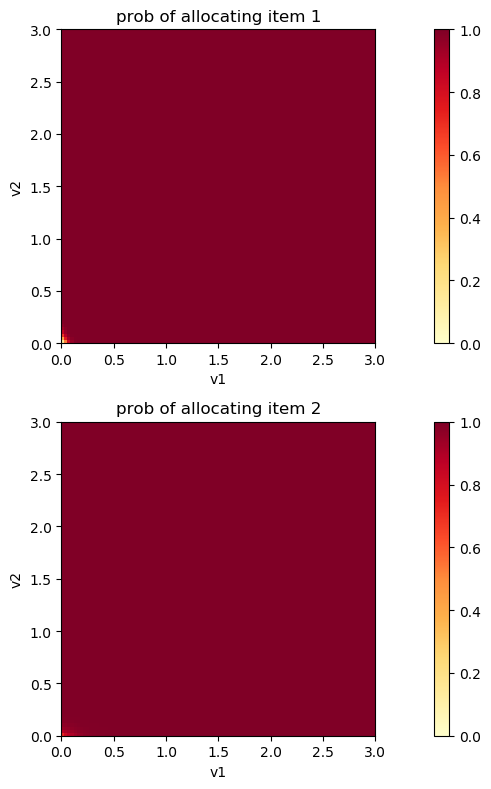

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
# cpu_model.sinkhorn_rounds = 100
# cpu_model.sinkhorn_epsilon = 1e-1
plot_12_model(cpu_model, 0.01, (0,3), (0,3))

In [18]:
cpu_model(torch.tensor([[[1.5, 0.]]]))

(tensor([[[1.0000, 0.9991]]], grad_fn=<ViewBackward>),
 tensor([[0.0237]], grad_fn=<MulBackward0>))

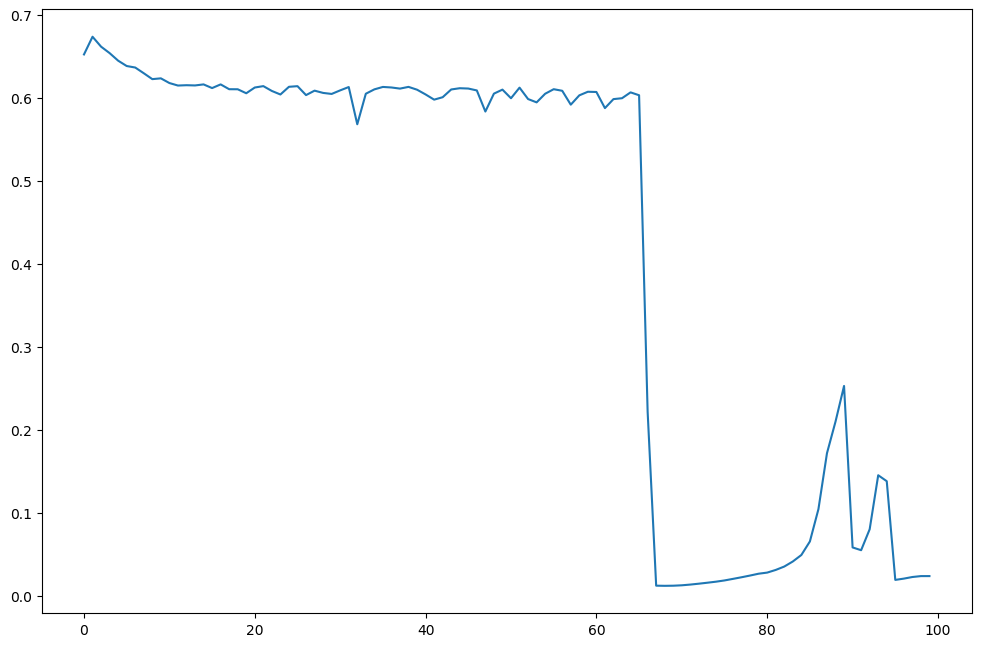

In [19]:
import matplotlib.pyplot as plt
plt.plot(mean_pay)

In [20]:
import pickle
to_pkl_lst = [mean_rgt, mean_pay, lagr_mults]
for i, fname in enumerate(['mean_rgt', 'mean_pay', 'lagr_mults']):
    with open(dir_name + fname, 'wb') as fp:
        pickle.dump(to_pkl_lst[i], fp)